# CMI Detect Behavior with Sensor Data - LightGBM Baseline

This notebook implements a baseline model using LightGBM for the CMI gesture classification competition.

## Approach
1. **Feature Engineering**: Extract statistical features from time series sensor data
2. **Model Training**: Use LightGBM with cross-validation
3. **Evaluation**: Analyze performance and feature importance
4. **Submission**: Generate competition submission file

In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Exploration

In [12]:
# Load data
print("Loading data...")

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
train_demographics = pd.read_csv('../data/train_demographics.csv')
test_demographics = pd.read_csv('../data/test_demographics.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Training demographics shape: {train_demographics.shape}")
print(f"Test demographics shape: {test_demographics.shape}")

Loading data...
Training data shape: (574945, 341)
Test data shape: (107, 336)
Training demographics shape: (81, 8)
Test demographics shape: (2, 8)


In [13]:
# Explore the data structure
print("=== Data Overview ===")
print(f"Unique sequences in train: {train_df['sequence_id'].nunique()}")
print(f"Unique sequences in test: {test_df['sequence_id'].nunique()}")
print(f"Unique subjects in train: {train_df['subject'].nunique()}")
print(f"Unique gestures: {train_df['gesture'].nunique()}")
print(f"Total sensor features: {len([col for col in train_df.columns if col.startswith(('acc_', 'rot_', 'thm_', 'tof_'))])}")

print("\n=== Sample Data ===")
display(train_df.head())

=== Data Overview ===
Unique sequences in train: 8151
Unique sequences in test: 2
Unique subjects in train: 81
Unique gestures: 18
Total sensor features: 332

=== Sample Data ===


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0


=== Gesture Distribution ===
gesture
Text on phone                                 58462
Neck - scratch                                56619
Eyebrow - pull hair                           44305
Forehead - scratch                            40923
Forehead - pull hairline                      40802
Above ear - pull hair                         40560
Neck - pinch skin                             40507
Eyelash - pull hair                           40218
Cheek - pinch skin                            40124
Wave hello                                    34356
Write name in air                             31267
Pull air toward your face                     30743
Feel around in tray and pull out an object    17114
Glasses on/off                                13542
Drink from bottle/cup                         13093
Scratch knee/leg skin                         12328
Write name on leg                             10138
Pinch knee/leg skin                            9844
Name: count, dtype: int64


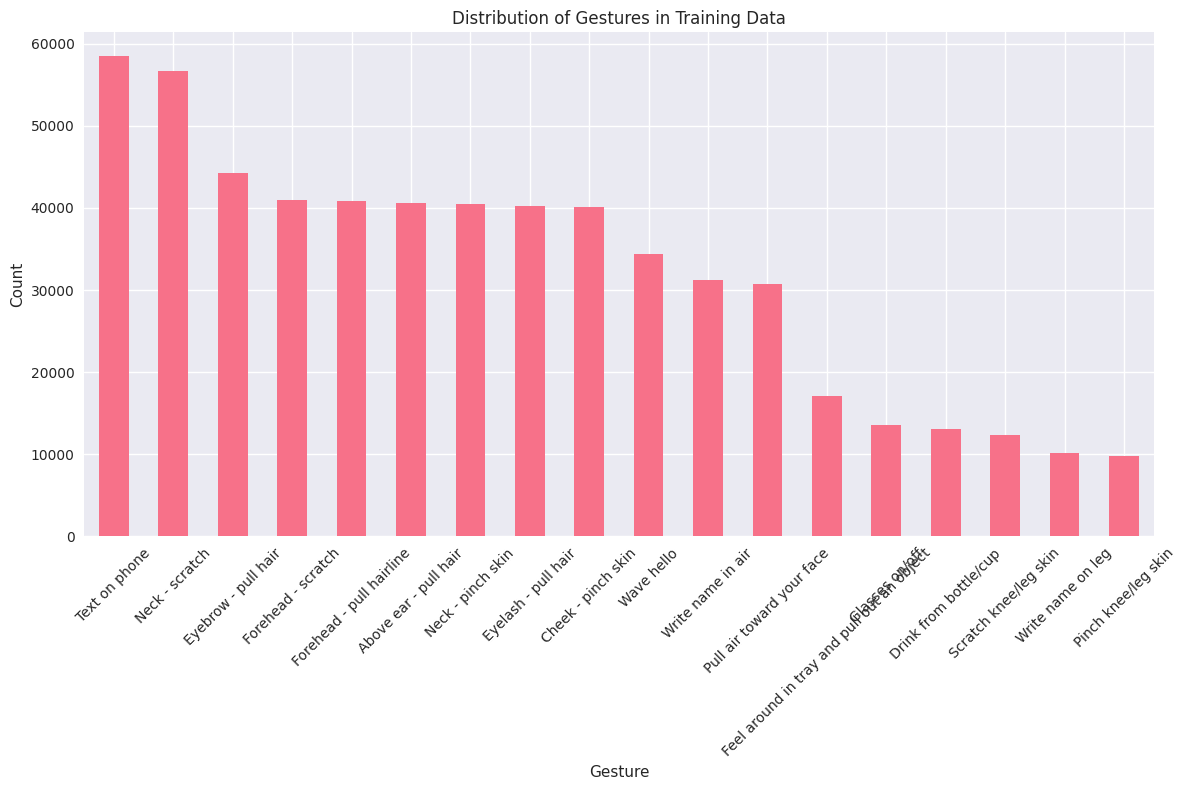

In [14]:
# Analyze target distribution
gesture_counts = train_df['gesture'].value_counts()
print("=== Gesture Distribution ===")
print(gesture_counts)

# Plot gesture distribution
plt.figure(figsize=(12, 8))
gesture_counts.plot(kind='bar', rot=45)
plt.title('Distribution of Gestures in Training Data')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

=== Sequence Length Statistics ===
count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
dtype: float64


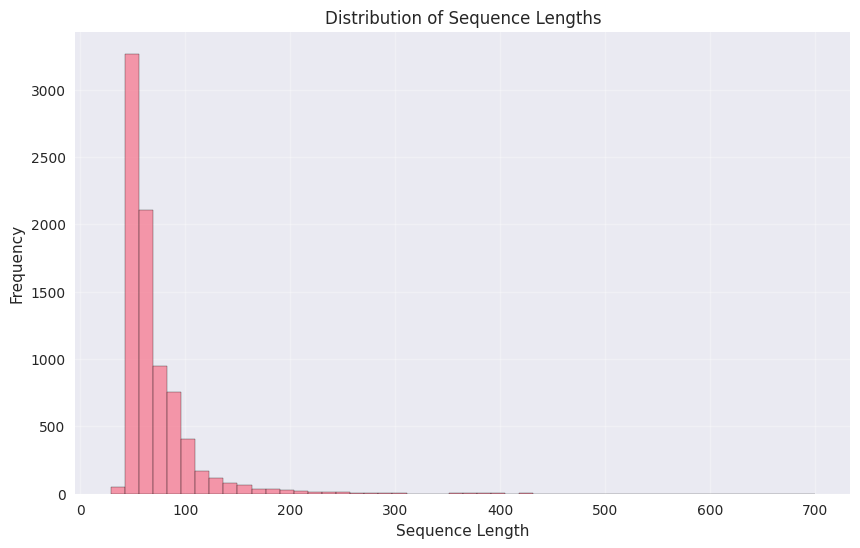

In [15]:
# Analyze sequence lengths
sequence_lengths = train_df.groupby('sequence_id').size()
print("=== Sequence Length Statistics ===")
print(sequence_lengths.describe())

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

=== Missing Values Analysis ===
Top 10 columns with most missing values:
tof_3_v15    414142
tof_3_v23    405172
tof_3_v6     399107
tof_3_v7     399016
tof_3_v14    398727
tof_5_v55    397562
tof_3_v31    395082
tof_5_v47    394825
tof_3_v22    391075
tof_5_v63    390915
dtype: int64


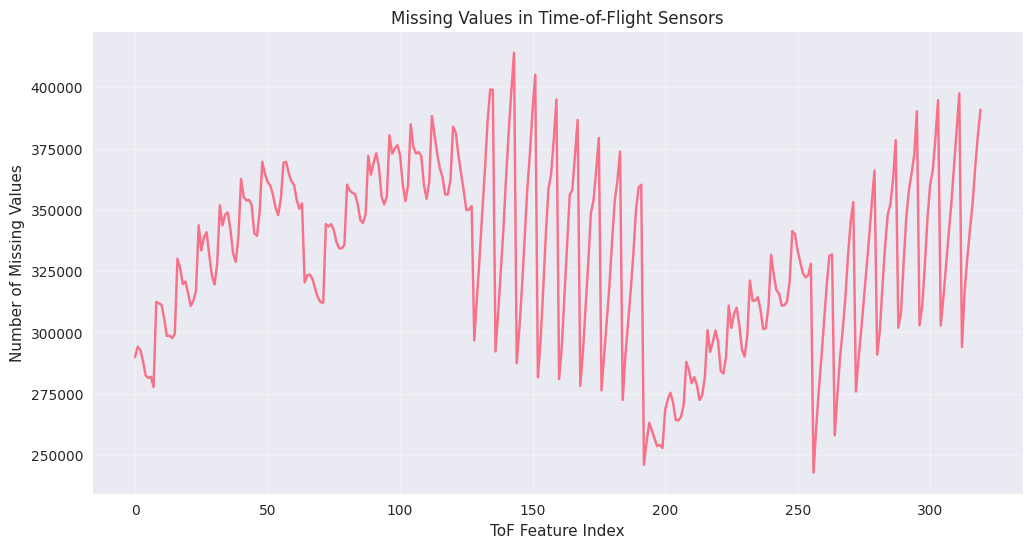

In [16]:
# Analyze missing values
print("=== Missing Values Analysis ===")

# Count -1.0 values (missing sensor readings)
sensor_cols = [col for col in train_df.columns if col.startswith(('acc_', 'rot_', 'thm_', 'tof_'))]
missing_counts = (train_df[sensor_cols] == -1.0).sum().sort_values(ascending=False)

print(f"Top 10 columns with most missing values:")
print(missing_counts.head(10))

# Plot missing values for ToF sensors
tof_cols = [col for col in sensor_cols if col.startswith('tof_')]
tof_missing = (train_df[tof_cols] == -1.0).sum()

plt.figure(figsize=(12, 6))
plt.plot(tof_missing.values)
plt.title('Missing Values in Time-of-Flight Sensors')
plt.xlabel('ToF Feature Index')
plt.ylabel('Number of Missing Values')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Feature Engineering

We'll extract statistical features from the time series data for each sensor modality.

In [17]:
class CMIFeatureExtractor:
    """Extract statistical features from time series sensor data"""
    
    def __init__(self):
        # Define sensor groups
        self.sensor_groups = {
            'acc': ['acc_x', 'acc_y', 'acc_z'],
            'rot': ['rot_w', 'rot_x', 'rot_y', 'rot_z'],
            'thm': [f'thm_{i}' for i in range(1, 6)],
            'tof': [f'tof_{i}_v{j}' for i in range(1, 6) for j in range(64)]
        }
        
    def extract_statistical_features(self, df_group):
        """Extract statistical features from a sequence group"""
        features = {}
        
        for sensor_type, columns in self.sensor_groups.items():
            # Get available columns
            available_cols = [col for col in columns if col in df_group.columns]
            
            if not available_cols:
                continue
                
            # Replace -1.0 with NaN for proper statistics
            sensor_data = df_group[available_cols].replace(-1.0, np.nan)
            
            # Basic statistics
            features[f'{sensor_type}_mean'] = sensor_data.mean().mean()
            features[f'{sensor_type}_std'] = sensor_data.std().mean()
            features[f'{sensor_type}_min'] = sensor_data.min().min()
            features[f'{sensor_type}_max'] = sensor_data.max().max()
            features[f'{sensor_type}_median'] = sensor_data.median().mean()
            
            # Derived statistics
            features[f'{sensor_type}_range'] = features[f'{sensor_type}_max'] - features[f'{sensor_type}_min']
            features[f'{sensor_type}_skew'] = sensor_data.skew().mean()
            features[f'{sensor_type}_kurtosis'] = sensor_data.kurtosis().mean()
            features[f'{sensor_type}_var'] = sensor_data.var().mean()
            
            # Percentiles
            features[f'{sensor_type}_q25'] = sensor_data.quantile(0.25).mean()
            features[f'{sensor_type}_q75'] = sensor_data.quantile(0.75).mean()
            features[f'{sensor_type}_iqr'] = features[f'{sensor_type}_q75'] - features[f'{sensor_type}_q25']
            
            # Signal properties
            features[f'{sensor_type}_missing_ratio'] = (sensor_data.isna().sum().sum() / sensor_data.size)
            features[f'{sensor_type}_energy'] = (sensor_data**2).sum().sum()
            features[f'{sensor_type}_rms'] = np.sqrt((sensor_data**2).mean().mean())
            
        return features
    
    def extract_sequence_features(self, df_sequence):
        """Extract sequence-level features"""
        features = {}
        
        # Sequence properties
        features['sequence_length'] = len(df_sequence)
        features['sequence_duration'] = df_sequence['sequence_counter'].max() - df_sequence['sequence_counter'].min()
        
        # Phase information
        if 'phase' in df_sequence.columns:
            features['num_phases'] = df_sequence['phase'].nunique()
        
        return features
    
    def transform(self, df):
        """Transform DataFrame to feature matrix"""
        features_list = []
        
        print(f"Extracting features from {df['sequence_id'].nunique()} sequences...")
        
        for i, (sequence_id, group) in enumerate(df.groupby('sequence_id')):
            if i % 1000 == 0:
                print(f"Processing sequence {i+1}/{df['sequence_id'].nunique()}")
            
            # Extract features
            stat_features = self.extract_statistical_features(group)
            seq_features = self.extract_sequence_features(group)
            
            # Combine features
            all_features = {**stat_features, **seq_features}
            all_features['sequence_id'] = sequence_id
            all_features['gesture'] = group['gesture'].iloc[0] if 'gesture' in group.columns else None
            all_features['subject'] = group['subject'].iloc[0]
            
            features_list.append(all_features)
        
        return pd.DataFrame(features_list)

# Initialize feature extractor
feature_extractor = CMIFeatureExtractor()
print("Feature extractor initialized!")

Feature extractor initialized!


In [18]:
# Extract features from training data
print("Extracting features from training data...")
train_features = feature_extractor.transform(train_df)

print(f"Training features shape: {train_features.shape}")
print(f"Feature columns: {len([col for col in train_features.columns if col not in ['sequence_id', 'gesture', 'subject']])}")

display(train_features.head())

Extracting features from training data...
Extracting features from 8151 sequences...
Processing sequence 1/8151
Processing sequence 1001/8151
Processing sequence 2001/8151
Processing sequence 3001/8151
Processing sequence 4001/8151
Processing sequence 5001/8151
Processing sequence 6001/8151
Processing sequence 7001/8151
Processing sequence 8001/8151
Training features shape: (8151, 66)
Feature columns: 63


,acc_mean,acc_std,acc_min,acc_max,acc_median,acc_range,acc_skew,acc_kurtosis,acc_var,acc_q25,...,tof_iqr,tof_missing_ratio,tof_energy,tof_rms,sequence_length,sequence_duration,num_phases,sequence_id,gesture,subject
0,5.215483,2.239986,-2.019531,9.792969,5.647135,11.812500,-0.381359,-0.560273,5.512003,4.252604,...,39.564063,0.419079,131264043.0,116.545412,57,56,2,SEQ_000007,Cheek - pinch skin,SUBJ_059520
1,5.097771,2.276872,-0.222656,11.074219,5.425781,11.296875,-0.165889,-1.182360,5.996598,2.517904,...,27.607744,0.458410,214867554.0,136.446686,68,67,2,SEQ_000008,Forehead - pull hairline,SUBJ_020948
2,-3.593775,1.730202,-10.945312,4.683594,-3.204427,15.628906,-0.655603,1.185998,3.341954,-4.199219,...,60.503236,0.741568,121734060.0,160.506018,53,52,2,SEQ_000013,Cheek - pinch skin,SUBJ_040282
3,-0.681971,2.604059,-8.078125,9.378906,-1.923177,17.457031,0.739271,0.157644,13.069416,-2.507812,...,11.942188,0.399846,18334115.0,51.863871,61,60,2,SEQ_000016,Write name on leg,SUBJ_052342
4,5.136839,2.419162,-3.164062,9.933594,5.623698,13.097656,-0.568465,-0.173903,6.502027,4.662760,...,14.005952,0.296296,213267929.0,132.964471,54,53,2,SEQ_000018,Forehead - pull hairline,SUBJ_032165


In [19]:
# Extract features from test data
print("Extracting features from test data...")
test_features = feature_extractor.transform(test_df)

print(f"Test features shape: {test_features.shape}")

Extracting features from test data...
Extracting features from 2 sequences...
Processing sequence 1/2
Test features shape: (2, 65)


In [20]:
# Merge with demographics data
print("Merging with demographics data...")

train_features = train_features.merge(train_demographics, on='subject', how='left')
test_features = test_features.merge(test_demographics, on='subject', how='left')

print(f"Final training features shape: {train_features.shape}")
print(f"Final test features shape: {test_features.shape}")

# Check for missing values
print(f"\nMissing values in training features: {train_features.isnull().sum().sum()}")
print(f"Missing values in test features: {test_features.isnull().sum().sum()}")

Merging with demographics data...
Final training features shape: (8151, 73)
Final test features shape: (2, 72)

Missing values in training features: 3152
Missing values in test features: 2


## 3. Feature Analysis and Visualization

Total features for modeling: 70


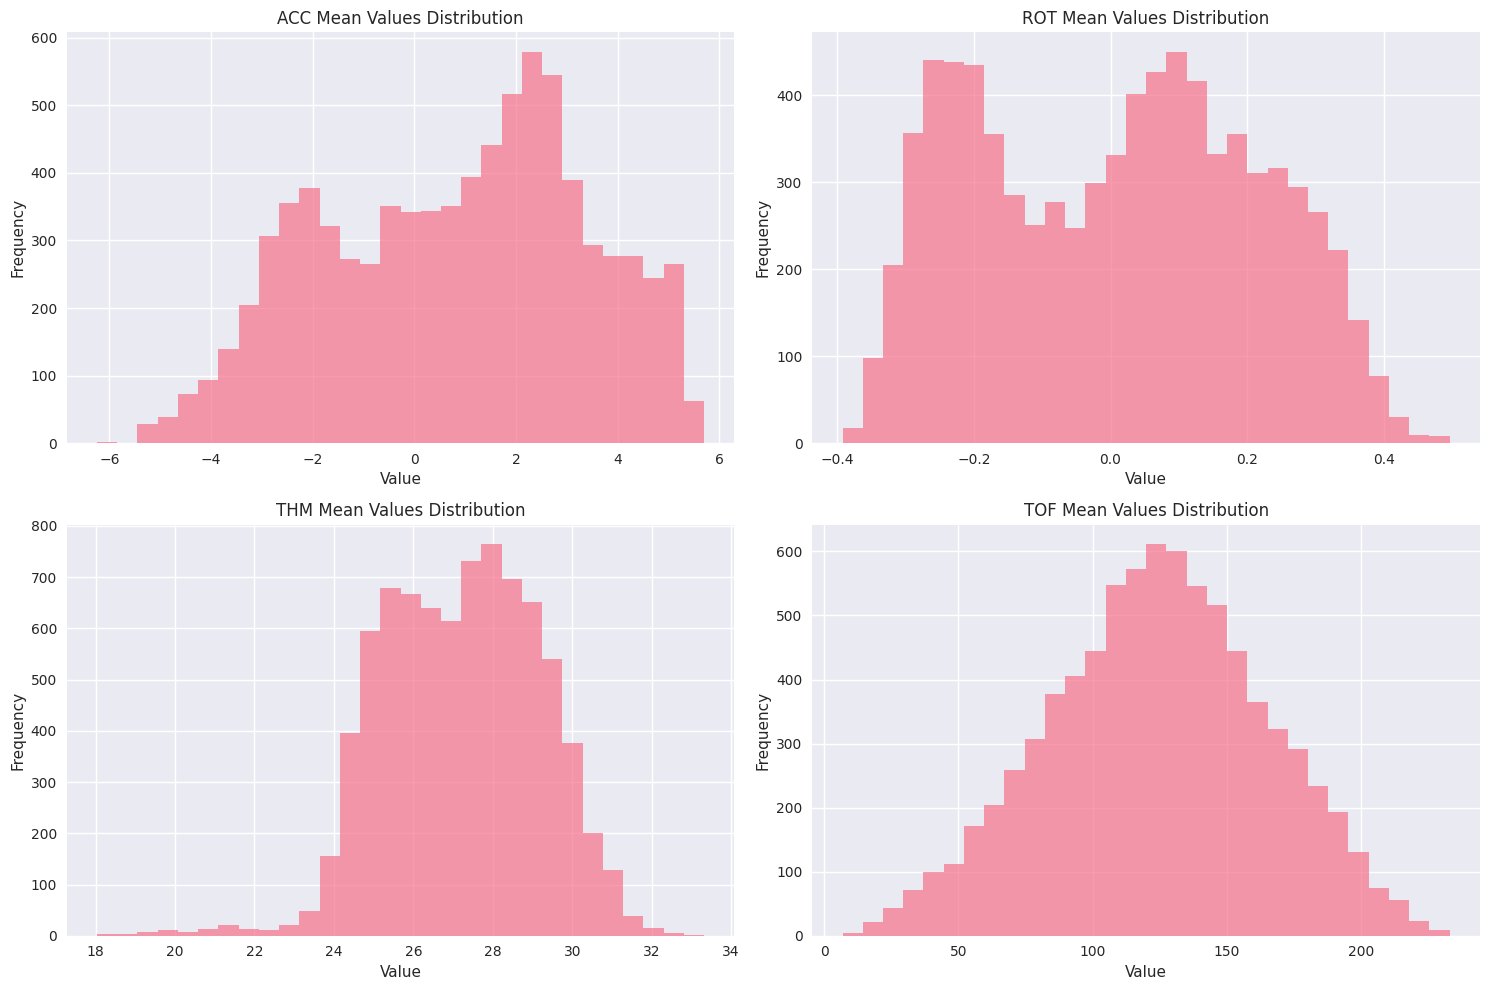

In [21]:
# Analyze feature distributions
feature_cols = [col for col in train_features.columns if col not in ['sequence_id', 'gesture', 'subject']]
print(f"Total features for modeling: {len(feature_cols)}")

# Plot feature distributions for each sensor type
sensor_types = ['acc', 'rot', 'thm', 'tof']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, sensor_type in enumerate(sensor_types):
    sensor_features = [col for col in feature_cols if col.startswith(sensor_type)]
    if sensor_features:
        # Plot mean values for this sensor type
        mean_col = f'{sensor_type}_mean'
        if mean_col in train_features.columns:
            train_features[mean_col].hist(bins=30, ax=axes[i], alpha=0.7)
            axes[i].set_title(f'{sensor_type.upper()} Mean Values Distribution')
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Top 15 features most correlated with target:
thm_max              0.320785
acc_min              0.292993
tof_missing_ratio    0.288323
thm_q75              0.283859
thm_median           0.271432
thm_rms              0.270397
acc_rms              0.263303
acc_range            0.259640
thm_mean             0.252917
thm_std              0.242606
thm_var              0.242458
thm_skew             0.240053
tof_var              0.229876
acc_skew             0.213797
tof_std              0.204498
Name: gesture_encoded, dtype: float64


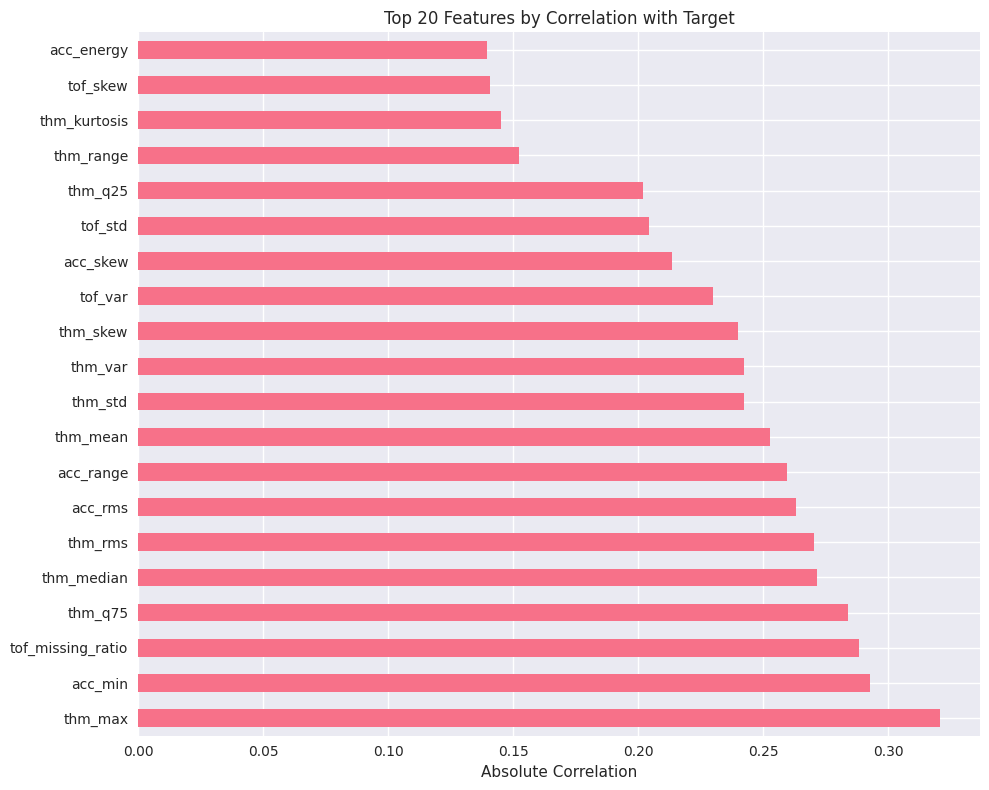

In [22]:
# Analyze correlations between features and target
# Encode target for correlation analysis
le_temp = LabelEncoder()
train_features['gesture_encoded'] = le_temp.fit_transform(train_features['gesture'])

# Calculate correlations with target
correlations = train_features[feature_cols + ['gesture_encoded']].corr()['gesture_encoded'].abs().sort_values(ascending=False)
correlations = correlations.drop('gesture_encoded')

print("Top 15 features most correlated with target:")
print(correlations.head(15))

# Plot top correlations
plt.figure(figsize=(10, 8))
correlations.head(20).plot(kind='barh')
plt.title('Top 20 Features by Correlation with Target')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

# Drop temporary column
train_features = train_features.drop('gesture_encoded', axis=1)

## 4. Model Training and Cross-Validation

In [23]:
# Prepare data for modeling
exclude_cols = ['sequence_id', 'gesture', 'subject', 'num_phases']
feature_names = [col for col in train_features.columns if col not in exclude_cols]

X_train = train_features[feature_names].fillna(0)
X_test = test_features[feature_names].fillna(0)

# Encode target
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_features['gesture'])

print(f"Training matrix shape: {X_train.shape}")
print(f"Test matrix shape: {X_test.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Class names: {label_encoder.classes_}")

Training matrix shape: (8151, 69)
Test matrix shape: (2, 69)
Number of classes: 18
Class names: ['Above ear - pull hair' 'Cheek - pinch skin' 'Drink from bottle/cup'
 'Eyebrow - pull hair' 'Eyelash - pull hair'
 'Feel around in tray and pull out an object' 'Forehead - pull hairline'
 'Forehead - scratch' 'Glasses on/off' 'Neck - pinch skin'
 'Neck - scratch' 'Pinch knee/leg skin' 'Pull air toward your face'
 'Scratch knee/leg skin' 'Text on phone' 'Wave hello' 'Write name in air'
 'Write name on leg']


In [24]:
# LightGBM parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("LightGBM parameters:")
for key, value in lgb_params.items():
    print(f"  {key}: {value}")

LightGBM parameters:
  objective: multiclass
  num_class: 18
  metric: multi_logloss
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.9
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42


In [25]:
# Cross-validation setup
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays for predictions and metrics
oof_predictions = np.zeros(len(X_train))
test_predictions = np.zeros((len(X_test), len(label_encoder.classes_)))
cv_scores = []
models = []
feature_importance = pd.DataFrame()

print(f"Starting {n_folds}-fold cross-validation...")

Starting 5-fold cross-validation...


In [26]:
# Training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
    
    print(f"Train size: {len(X_fold_train)}, Validation size: {len(X_fold_val)}")
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
    val_data = lgb.Dataset(X_fold_val, label=y_fold_val, reference=train_data)
    
    # Train model
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        num_boost_round=1000,
        valid_names=['train', 'val'],
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
    )
    
    # Predictions
    val_pred = model.predict(X_fold_val)
    oof_predictions[val_idx] = val_pred.argmax(axis=1)
    test_predictions += model.predict(X_test) / n_folds
    
    # Calculate fold score
    fold_score = accuracy_score(y_fold_val, val_pred.argmax(axis=1))
    cv_scores.append(fold_score)
    print(f"Fold {fold + 1} accuracy: {fold_score:.4f}")
    
    # Store model and feature importance
    models.append(model)
    
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = feature_names
    fold_importance['importance'] = model.feature_importance()
    fold_importance['fold'] = fold + 1
    feature_importance = pd.concat([feature_importance, fold_importance])

# Calculate overall CV score
overall_cv_score = accuracy_score(y_train, oof_predictions)
print(f"\n=== Cross-Validation Results ===")
print(f"Individual fold scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Overall CV score: {overall_cv_score:.4f}")


=== Fold 1/5 ===
Train size: 6520, Validation size: 1631
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.19472	val's multi_logloss: 1.4428
[200]	train's multi_logloss: 0.0357743	val's multi_logloss: 1.51003
Early stopping, best iteration is:
[104]	train's multi_logloss: 0.18094	val's multi_logloss: 1.44194
Fold 1 accuracy: 0.4825

=== Fold 2/5 ===
Train size: 6521, Validation size: 1630
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.19581	val's multi_logloss: 1.43865
[200]	train's multi_logloss: 0.0361585	val's multi_logloss: 1.51906
Early stopping, best iteration is:
[102]	train's multi_logloss: 0.188714	val's multi_logloss: 1.43734
Fold 2 accuracy: 0.4902

=== Fold 3/5 ===
Train size: 6521, Validation size: 1630
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.194182	val's multi_logloss: 1.46162
[200]	train's multi_logloss: 0.0351891	val's multi_logl

## 5. Model Evaluation and Analysis

Top 20 most important features:
                     mean        std
feature                             
acc_rms            1631.6  71.619132
acc_min            1562.6  33.738702
acc_skew           1444.4  48.972441
tof_energy         1410.6  48.767817
tof_missing_ratio  1374.4  31.532523
thm_max            1261.8  39.417001
rot_skew           1211.0  83.336667
tof_kurtosis       1177.8  52.646937
thm_skew           1163.4  68.580610
acc_std            1162.0  75.772686
rot_max            1159.2  33.297147
rot_mean           1142.2  53.298218
rot_median         1134.0  61.733297
rot_min            1127.4  70.400994
acc_median         1107.6  66.489097
acc_kurtosis       1104.4  30.468016
tof_skew           1079.8  50.066955
rot_q25            1062.8  72.378864
acc_max            1029.0  85.959293
rot_range          1028.0  35.895682


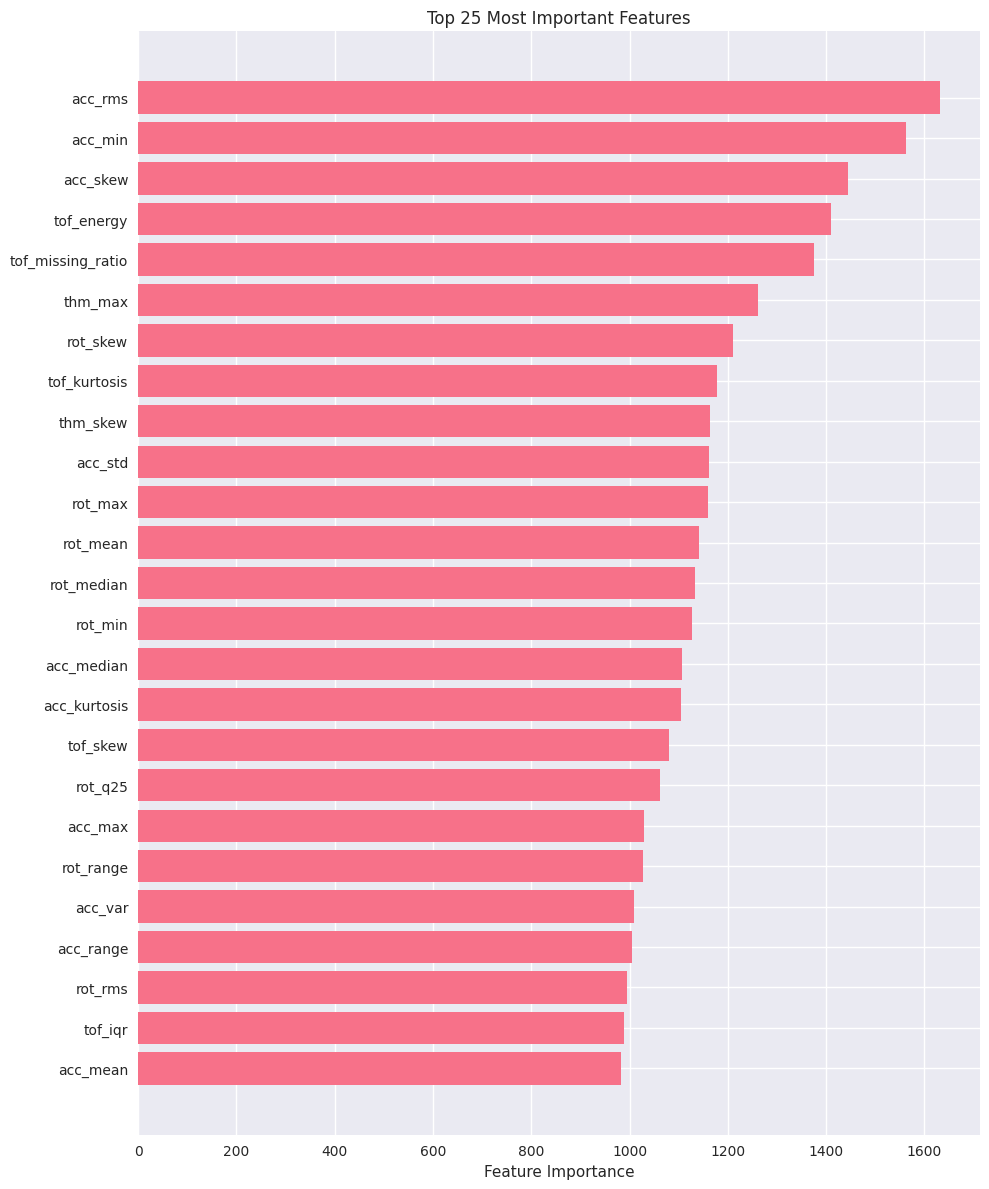

In [27]:
# Feature importance analysis
feature_importance_avg = feature_importance.groupby('feature')['importance'].agg(['mean', 'std']).sort_values('mean', ascending=False)

print("Top 20 most important features:")
print(feature_importance_avg.head(20))

# Plot feature importance
plt.figure(figsize=(10, 12))
top_features = feature_importance_avg.head(25)
plt.barh(range(len(top_features)), top_features['mean'])
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Feature Importance')
plt.title('Top 25 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

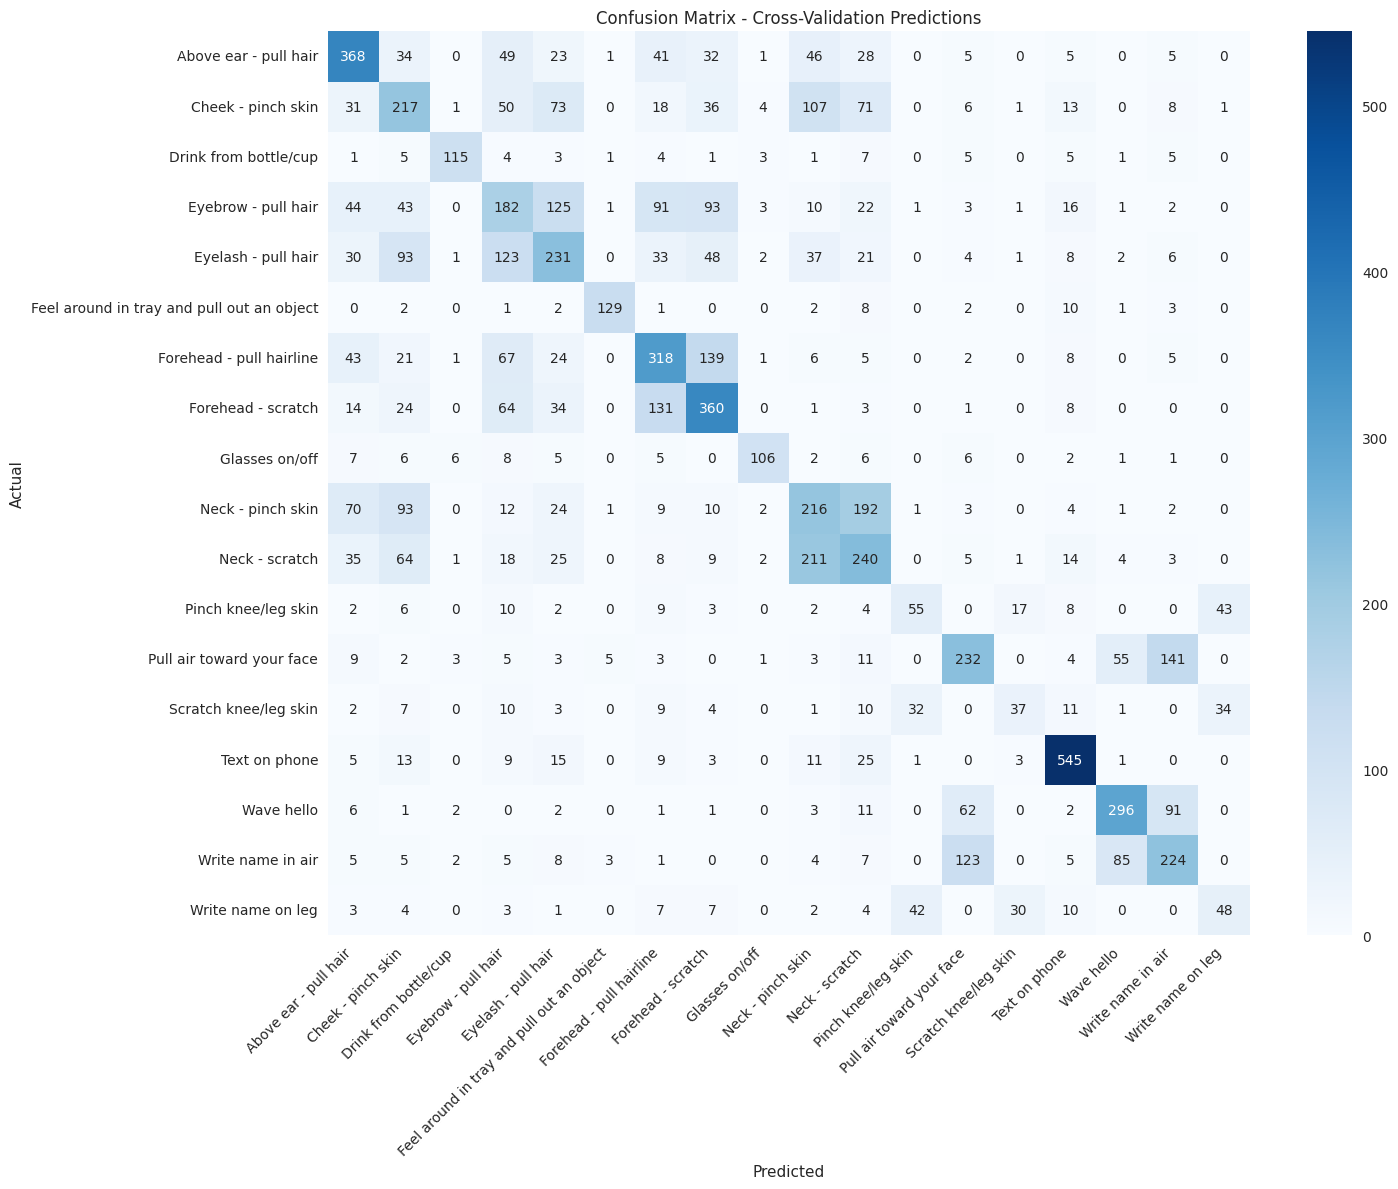

In [28]:
# Confusion matrix
cm = confusion_matrix(y_train, oof_predictions)
gesture_names = label_encoder.classes_

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gesture_names, yticklabels=gesture_names)
plt.title('Confusion Matrix - Cross-Validation Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
# Classification report
print("=== Classification Report ===")
print(classification_report(y_train, oof_predictions, target_names=gesture_names))

=== Classification Report ===
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.55      0.58      0.56       638
                        Cheek - pinch skin       0.34      0.34      0.34       637
                     Drink from bottle/cup       0.87      0.71      0.78       161
                       Eyebrow - pull hair       0.29      0.29      0.29       638
                       Eyelash - pull hair       0.38      0.36      0.37       640
Feel around in tray and pull out an object       0.91      0.80      0.85       161
                  Forehead - pull hairline       0.46      0.50      0.48       640
                        Forehead - scratch       0.48      0.56      0.52       640
                            Glasses on/off       0.85      0.66      0.74       161
                         Neck - pinch skin       0.32      0.34      0.33       640
                            Neck - scratch   

Per-class performance (sorted by F1-score):


,gesture,precision,recall,f1_score,support
5,Feel around in tray and pull out an object,0.914894,0.801242,0.854305,161
14,Text on phone,0.803835,0.851562,0.827011,640
2,Drink from bottle/cup,0.871212,0.714286,0.784983,161
8,Glasses on/off,0.848000,0.658385,0.741259,161
15,Wave hello,0.659243,0.619247,0.638619,478
0,Above ear - pull hair,0.545185,0.576803,0.560548,638
7,Forehead - scratch,0.482574,0.562500,0.519481,640
12,Pull air toward your face,0.505447,0.486373,0.495726,477
6,Forehead - pull hairline,0.455587,0.496875,0.475336,640
16,Write name in air,0.451613,0.469602,0.460432,477


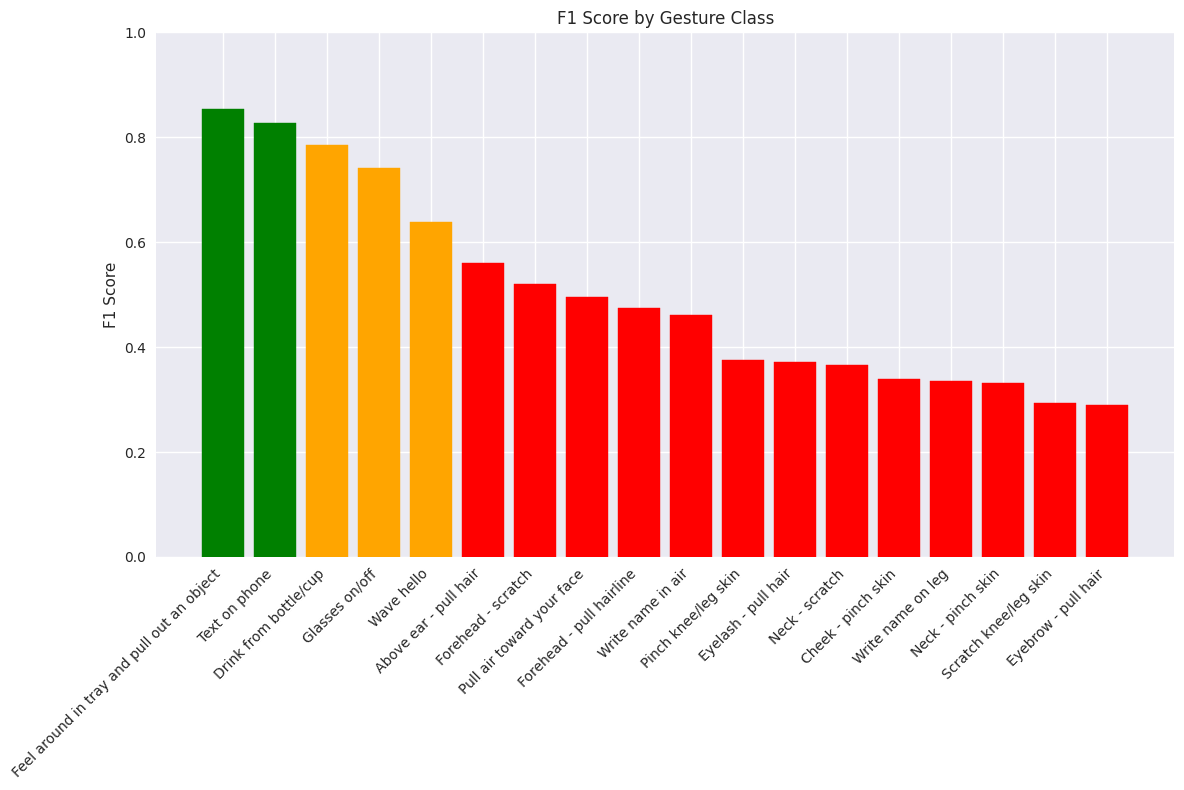

In [30]:
# Analyze per-class performance
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_train, oof_predictions)

performance_df = pd.DataFrame({
    'gesture': gesture_names,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'support': support
}).sort_values('f1_score', ascending=False)

print("Per-class performance (sorted by F1-score):")
display(performance_df)

# Plot per-class F1 scores
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(performance_df)), performance_df['f1_score'])
plt.xticks(range(len(performance_df)), performance_df['gesture'], rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('F1 Score by Gesture Class')
plt.ylim(0, 1)

# Color bars by performance
for i, bar in enumerate(bars):
    f1 = performance_df.iloc[i]['f1_score']
    if f1 > 0.8:
        bar.set_color('green')
    elif f1 > 0.6:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

## 6. Test Predictions and Submission

Test prediction distribution:
Eyelash - pull hair    2
Name: count, dtype: int64


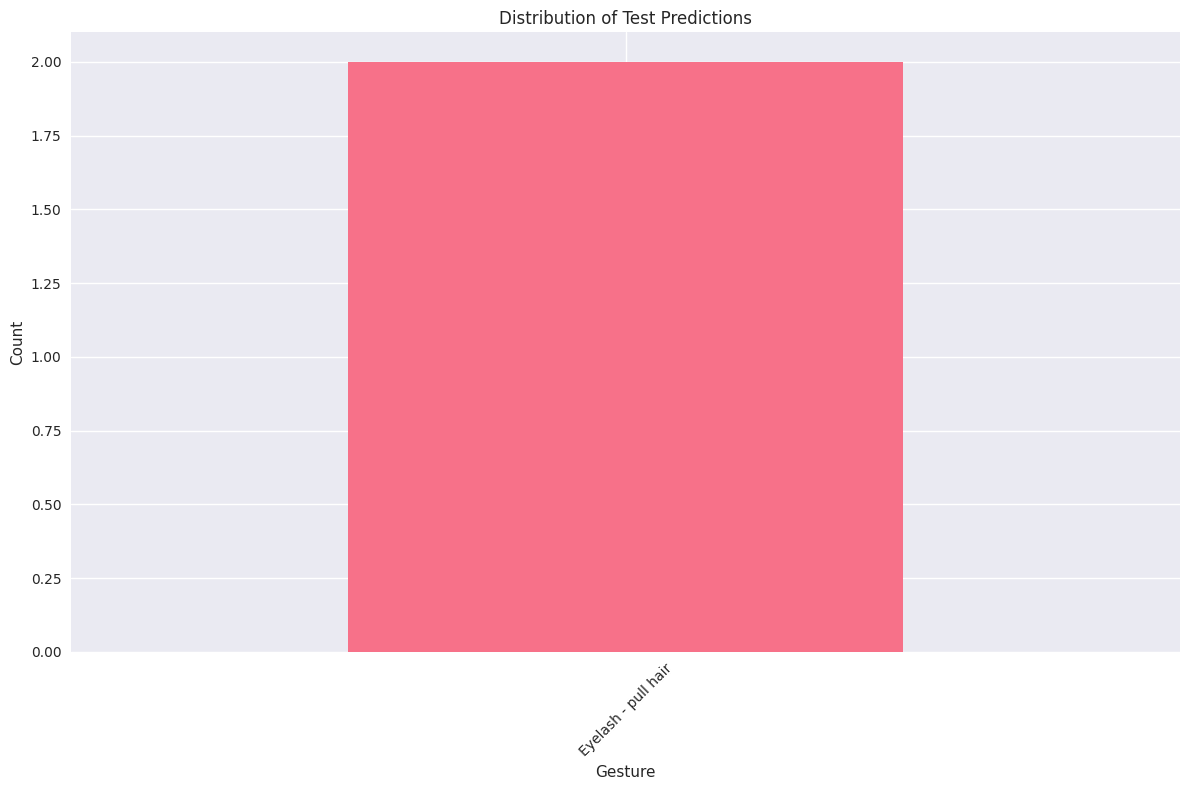

In [31]:
# Generate test predictions
test_pred_classes = test_predictions.argmax(axis=1)
predicted_gestures = label_encoder.inverse_transform(test_pred_classes)

print("Test prediction distribution:")
pred_counts = pd.Series(predicted_gestures).value_counts()
print(pred_counts)

# Plot prediction distribution
plt.figure(figsize=(12, 8))
pred_counts.plot(kind='bar', rot=45)
plt.title('Distribution of Test Predictions')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'sequence_id': test_features['sequence_id'],
    'gesture': predicted_gestures
})

# Save submission
submission.to_csv('../results/lightgbm_baseline_submission.csv', index=False)

print(f"Submission file created: ../results/lightgbm_baseline_submission.csv")
print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
display(submission.head())

Submission file created: ../results/lightgbm_baseline_submission.csv
Submission shape: (2, 2)

First few predictions:


,sequence_id,gesture
0,SEQ_000001,Eyelash - pull hair
1,SEQ_000011,Eyelash - pull hair


## 7. Model Insights and Next Steps

Importance by sensor type:
  ACC: 15593.0
  ROT: 14030.0
  TOF: 11372.6
  THM: 11150.6


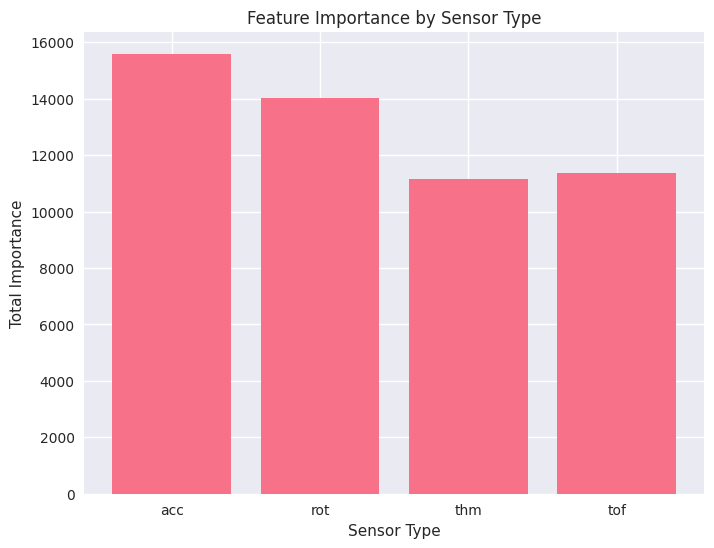

In [33]:
# Analyze which sensor types are most important
sensor_importance = {}
for sensor_type in ['acc', 'rot', 'thm', 'tof']:
    sensor_features = feature_importance_avg[feature_importance_avg.index.str.startswith(sensor_type)]
    sensor_importance[sensor_type] = sensor_features['mean'].sum()

print("Importance by sensor type:")
for sensor, importance in sorted(sensor_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {sensor.upper()}: {importance:.1f}")

# Plot sensor importance
plt.figure(figsize=(8, 6))
sensors = list(sensor_importance.keys())
importances = list(sensor_importance.values())
plt.bar(sensors, importances)
plt.title('Feature Importance by Sensor Type')
plt.xlabel('Sensor Type')
plt.ylabel('Total Importance')
plt.show()

In [34]:
# Summary of results
print("=" * 60)
print("LIGHTGBM BASELINE MODEL SUMMARY")
print("=" * 60)
print(f"Cross-validation accuracy: {overall_cv_score:.4f}")
print(f"Mean fold accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Number of features used: {len(feature_names)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Training sequences: {len(train_features)}")
print(f"Test sequences: {len(test_features)}")
print()
print("Most important sensor types:")
for sensor, importance in sorted(sensor_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {sensor.upper()}: {importance:.1f}")
print()
print("Best performing gesture classes (F1 > 0.8):")
high_performance = performance_df[performance_df['f1_score'] > 0.8]
for _, row in high_performance.iterrows():
    print(f"  {row['gesture']}: {row['f1_score']:.3f}")
print()
print("Areas for improvement:")
low_performance = performance_df[performance_df['f1_score'] < 0.6]
for _, row in low_performance.iterrows():
    print(f"  {row['gesture']}: {row['f1_score']:.3f}")
print("=" * 60)

LIGHTGBM BASELINE MODEL SUMMARY
Cross-validation accuracy: 0.4808
Mean fold accuracy: 0.4808 ± 0.0075
Number of features used: 69
Number of classes: 18
Training sequences: 8151
Test sequences: 2

Most important sensor types:
  ACC: 15593.0
  ROT: 14030.0
  TOF: 11372.6
  THM: 11150.6

Best performing gesture classes (F1 > 0.8):
  Feel around in tray and pull out an object: 0.854
  Text on phone: 0.827

Areas for improvement:
  Above ear - pull hair: 0.561
  Forehead - scratch: 0.519
  Pull air toward your face: 0.496
  Forehead - pull hairline: 0.475
  Write name in air: 0.460
  Pinch knee/leg skin: 0.375
  Eyelash - pull hair: 0.372
  Neck - scratch: 0.365
  Cheek - pinch skin: 0.340
  Write name on leg: 0.334
  Neck - pinch skin: 0.331
  Scratch knee/leg skin: 0.294
  Eyebrow - pull hair: 0.289
